In [38]:
transformer_state = {
    "soc": 0.42,          # Estimated SoC
    "soh": 0.93,          # Estimated SoH
    "temp": 305.0,        # Current temperature (K)
    "confidence": 0.91    # Optional
}

In [39]:
import numpy as np

In [40]:
# Battery and Safety Parameters

BATTERY_PARAMS = {
    "capacity_Ah": 2.0,        # NASA cells ~2Ah
    "R0_nominal": 0.05,        # Ohmic resistance (ohms)

    "V_max": 4.2,
    "V_min": 3.0,

    "T_amb": 298.0,            # 25C
    "T_max": 333.0,            # 60C safety limit

    "R_th": 2.0,
    "C_th": 400.0,

    "dt": 1.0                 # 1 second
}

In [41]:
# OCV Model

def ocv_function(soc):
    return 3.0 + 1.2 * soc

In [42]:
# ECM step (SoH-aware resistance)
# Internal resistance increases as SoH drops

def ecm_step(soc, soh, current, dt, params):
    Q = params["capacity_Ah"] * 3600

    # Charging → SoC increases
    soc_next = soc + (abs(current) * dt) / Q
    soc_next = np.clip(soc_next, 0.0, 1.0)

    # Aging increases resistance
    R0 = params["R0_nominal"] * (1.0 / soh)

    voltage = ocv_function(soc) + abs(current) * R0
    return soc_next, voltage, R0

In [43]:
# Thermal Model

def thermal_step(temp, current, R0, params, dt):
    heat_gen = (current ** 2) * R0
    heat_loss = (temp - params["T_amb"]) / params["R_th"]
    return temp + (dt / params["C_th"]) * (heat_gen - heat_loss)

In [44]:
# Degradation Proxy
# SoH loss accelerates at high temperature and current

def degradation_step(soh, current, temp, dt):
    stress = abs(current) * max(0.0, temp - 298.0)
    delta = 5e-9 * stress * dt
    return max(0.0, soh - delta)

In [45]:
# Core simulation function (conditioned on Transformer output)
# This is the synthetic data generator used by the optimizer

def simulate_charging(profile, transformer_state, params, log_trajectory=False):
    soc = transformer_state["soc"]
    soh = transformer_state["soh"]
    temp = transformer_state["temp"]

    dt = params["dt"]

    soc_traj = []
    temp_traj = []
    soh_traj = []

    for current in profile:
        soc, voltage, R0 = ecm_step(soc, soh, current, dt, params)
        temp = thermal_step(temp, current, R0, params, dt)
        soh = degradation_step(soh, current, temp, dt)

        if voltage > params["V_max"] or temp > params["T_max"]:
            return None

        if log_trajectory:
            soc_traj.append(soc)
            temp_traj.append(temp)
            soh_traj.append(soh)

    charging_time = len(profile) * dt
    soh_loss = transformer_state["soh"] - soh

    if log_trajectory:
        return charging_time, soh_loss, soc_traj, temp_traj, soh_traj
    else:
        return charging_time, temp, soh_loss, soc


In [46]:
# Fitness function (single-objective GA)

def fitness_function(sim_result):
    if sim_result is None:
        return -1e6

    charging_time, peak_temp, soh_loss, final_soc = sim_result

    soc_gain = final_soc
    temp_penalty = max(0.0, peak_temp - 318.0)

    return (
        + 100.0 * soc_gain
        - 1e4 * soh_loss
        - 10.0 * temp_penalty
    )

In [47]:
# Genetic Algorithm (GA)
# Hyperparameters

POP_SIZE = 40
N_GENERATIONS = 25

HORIZON_SEC = 1200          # 20 minutes
DT = 1.0
N_GENES = int(HORIZON_SEC / DT)

I_MIN, I_MAX = 0.5, 4.0    # NASA-scale currents

ELITE_FRAC = 0.2
MUT_PROB = 0.1
MUT_STD = 0.3

In [48]:
# GA helpers

def initialize_population():
    return [
        np.random.uniform(I_MIN, I_MAX, N_GENES)
        for _ in range(POP_SIZE)
    ]


def crossover(p1, p2):
    point = np.random.randint(1, N_GENES - 1)
    return np.concatenate([p1[:point], p2[point:]])


def mutate(ind):
    for i in range(len(ind)):
        if np.random.rand() < MUT_PROB:
            ind[i] += np.random.normal(0, MUT_STD)
    return np.clip(ind, I_MIN, I_MAX)


# Transformer output (input to optimizer)
transformer_state = {
    "soc": 0.45,
    "soh": 0.95,
    "temp": 300.0
}

population = initialize_population()
best_fitness_history = []

for gen in range(N_GENERATIONS):
    fitnesses = []

    for individual in population:
        sim = simulate_charging(
            individual,
            transformer_state,
            BATTERY_PARAMS
        )
        fitnesses.append(fitness_function(sim))

    fitnesses = np.array(fitnesses)

    best_idx = np.argmax(fitnesses)
    best_fitness_history.append(fitnesses[best_idx])

    elite_count = int(ELITE_FRAC * POP_SIZE)
    elite_idx = np.argsort(fitnesses)[-elite_count:]
    elites = [population[i] for i in elite_idx]

    next_population = elites.copy()
    while len(next_population) < POP_SIZE:
        i1, i2 = np.random.choice(len(elites), 2, replace=False)
        child = crossover(elites[i1], elites[i2])
        child = mutate(child)
        next_population.append(child)

    population = next_population

    print(f"Gen {gen+1}/{N_GENERATIONS} | Best fitness: {best_fitness_history[-1]:.3f}")

best_profile = population[np.argmax(fitnesses)]

Gen 1/25 | Best fitness: 83.342
Gen 2/25 | Best fitness: 83.342
Gen 3/25 | Best fitness: 83.342
Gen 4/25 | Best fitness: 83.585
Gen 5/25 | Best fitness: 83.585
Gen 6/25 | Best fitness: 83.653
Gen 7/25 | Best fitness: 83.702
Gen 8/25 | Best fitness: 83.757
Gen 9/25 | Best fitness: 83.766
Gen 10/25 | Best fitness: 83.811
Gen 11/25 | Best fitness: 83.816
Gen 12/25 | Best fitness: 83.816
Gen 13/25 | Best fitness: 83.820
Gen 14/25 | Best fitness: 83.902
Gen 15/25 | Best fitness: 83.902
Gen 16/25 | Best fitness: 83.902
Gen 17/25 | Best fitness: 83.902
Gen 18/25 | Best fitness: 83.927
Gen 19/25 | Best fitness: 84.022
Gen 20/25 | Best fitness: 84.074
Gen 21/25 | Best fitness: 84.081
Gen 22/25 | Best fitness: 84.118
Gen 23/25 | Best fitness: 84.131
Gen 24/25 | Best fitness: 84.173
Gen 25/25 | Best fitness: 84.234


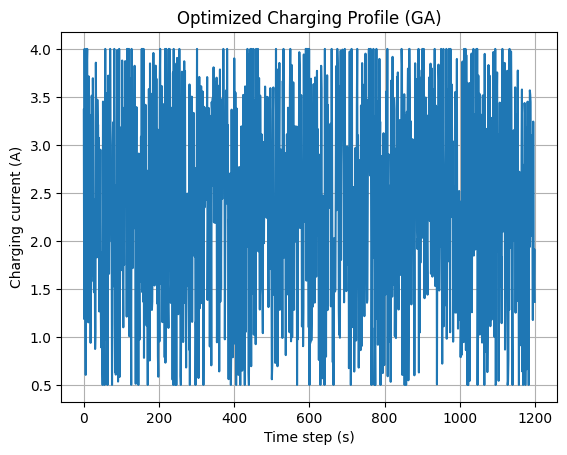

In [49]:
import matplotlib.pyplot as plt

plt.plot(best_profile)
plt.xlabel("Time step (s)")
plt.ylabel("Charging current (A)")
plt.title("Optimized Charging Profile (GA)")
plt.grid(True)
plt.show()

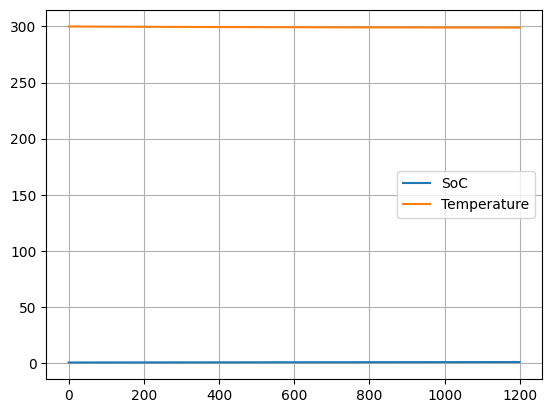

In [50]:
soc = transformer_state["soc"]
soh = transformer_state["soh"]
temp = transformer_state["temp"]

soc_traj, temp_traj = [], []

for i in best_profile:
    soc, voltage, R0 = ecm_step(soc, soh, i, BATTERY_PARAMS["dt"], BATTERY_PARAMS)
    temp = thermal_step(temp, i, R0, BATTERY_PARAMS, BATTERY_PARAMS["dt"])
    soh = degradation_step(soh, i, temp, BATTERY_PARAMS["dt"])
    soc_traj.append(soc)
    temp_traj.append(temp)

plt.plot(soc_traj, label="SoC")
plt.plot(temp_traj, label="Temperature")
plt.legend()
plt.grid(True)
plt.show()

NSGA - II

In [51]:
!pip3 install pymoo


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [52]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

In [53]:
# Define NSGA-II problem
# Each individual = one charging profile
# Each evaluation = one synthetic rollout

class ChargingNSGA2Problem(Problem):

    def __init__(self, transformer_state):
        super().__init__(
            n_var=N_GENES,
            n_obj=3,
            n_constr=0,
            xl=I_MIN,
            xu=I_MAX
        )
        self.transformer_state = transformer_state

    def _evaluate(self, X, out, *args, **kwargs):
        F = []

        for individual in X:
            sim = simulate_charging(
                individual,
                self.transformer_state,
                BATTERY_PARAMS
            )

            if sim is None:
                # Penalise unsafe solutions
                F.append([1e3, 1e3, 1e3])
            else:
                charging_time, peak_temp, soh_loss, final_soc = sim
                soc_gain = final_soc - self.transformer_state["soc"]

                # NSGA-II minimises by default
                F.append([
                    -soc_gain,      # maximise SoC gain
                    peak_temp,      # minimise temperature
                    soh_loss        # minimise degradation
                ])

        out["F"] = np.array(F)


In [54]:
# Configure NSGA-II

algorithm = NSGA2(
    pop_size=60,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

In [55]:
# Run NSGA-II

problem = ChargingNSGA2Problem(transformer_state)

result = minimize(
    problem,
    algorithm,
    termination=("n_gen", 40),
    seed=1,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       60 |     43 |             - |             -
     2 |      120 |     60 |  0.0403239897 |             f
     3 |      180 |     60 |  0.0484965069 |         ideal
     4 |      240 |     60 |  0.0612513740 |         ideal
     5 |      300 |     60 |  0.0401114966 |         ideal
     6 |      360 |     60 |  0.1251115912 |         ideal
     7 |      420 |     60 |  0.0923250225 |         ideal
     8 |      480 |     60 |  0.0313698017 |         ideal
     9 |      540 |     60 |  0.0118022005 |         ideal
    10 |      600 |     60 |  0.0446659592 |         ideal
    11 |      660 |     60 |  0.0714569211 |         ideal
    12 |      720 |     60 |  0.0171257525 |             f
    13 |      780 |     60 |  0.0144579772 |         ideal
    14 |      840 |     60 |  0.0115377657 |             f
    15 |      900 |     60 |  0.0225936978 |         ideal
    16 |      960 |     60 |  0.0179059187 |            

In [56]:
# Extracting pareto-optimal solutions

pareto_profiles = result.X        # charging profiles
pareto_objectives = result.F     # [-soc_gain, temp, soh_loss]

soc_gain = -pareto_objectives[:, 0]
peak_temp = pareto_objectives[:, 1]
soh_loss = pareto_objectives[:, 2]

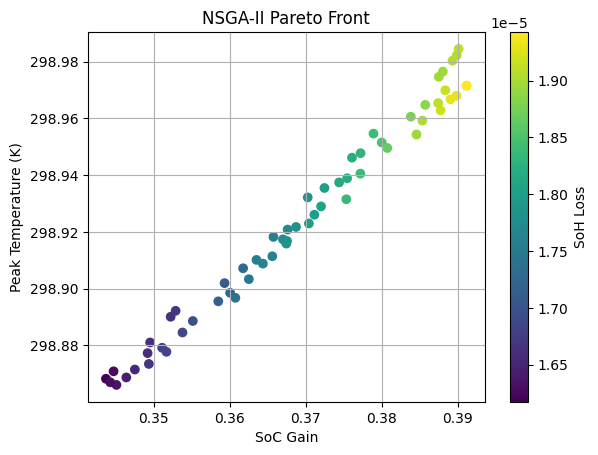

In [57]:
# Plot Pareto front

import matplotlib.pyplot as plt

plt.scatter(soc_gain, peak_temp, c=soh_loss, cmap="viridis")
plt.xlabel("SoC Gain")
plt.ylabel("Peak Temperature (K)")
plt.colorbar(label="SoH Loss")
plt.title("NSGA-II Pareto Front")
plt.grid(True)
plt.show()

In [58]:
# Pick representative solutions (for Meta-Agent)

# Fast charging (max SoC gain)
fast_idx = np.argmax(soc_gain)

# Battery-friendly (min SoH loss)
gentle_idx = np.argmin(soh_loss)

# Balanced (closest to median)
balanced_idx = np.argsort(
    np.abs(soc_gain - np.median(soc_gain))
)[0]

selected_profiles = {
    "fast": pareto_profiles[fast_idx],
    "balanced": pareto_profiles[balanced_idx],
    "gentle": pareto_profiles[gentle_idx]
}

In [59]:
# Representative indices
fast_idx = np.argmax(soc_gain)          # max SoC gain
gentle_idx = np.argmin(soh_loss)        # min degradation
balanced_idx = np.argsort(
    np.abs(soc_gain - np.median(soc_gain))
)[0]

profiles = {
    "Fast charging": pareto_profiles[fast_idx],
    "Balanced": pareto_profiles[balanced_idx],
    "Battery-friendly": pareto_profiles[gentle_idx]
}

In [60]:
def rollout(profile, transformer_state):
    soc = transformer_state["soc"]
    soh = transformer_state["soh"]
    temp = transformer_state["temp"]

    soc_traj, temp_traj = [], []

    for current in profile:
        soc, voltage, R0 = ecm_step(
            soc, soh, current,
            BATTERY_PARAMS["dt"],
            BATTERY_PARAMS
        )
        temp = thermal_step(
            temp, current, R0,
            BATTERY_PARAMS,
            BATTERY_PARAMS["dt"]
        )
        soh = degradation_step(
            soh, current, temp,
            BATTERY_PARAMS["dt"]
        )

        soc_traj.append(soc)
        temp_traj.append(temp)

    return soc_traj, temp_traj


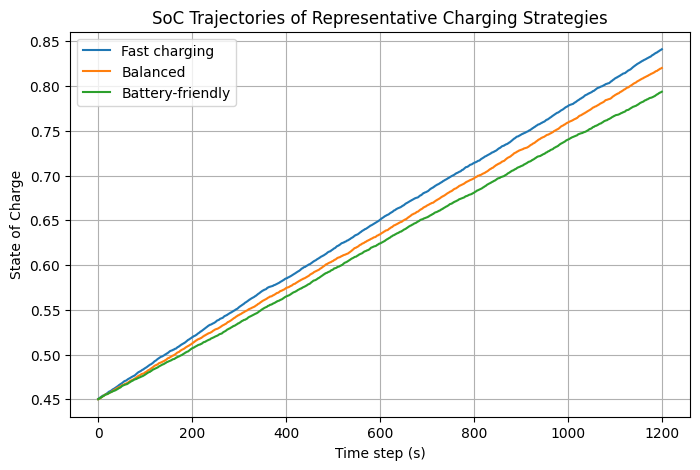

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for label, profile in profiles.items():
    soc_traj, _ = rollout(profile, transformer_state)
    plt.plot(soc_traj, label=label)

plt.xlabel("Time step (s)")
plt.ylabel("State of Charge")
plt.title("SoC Trajectories of Representative Charging Strategies")
plt.legend()
plt.grid(True)
plt.show()

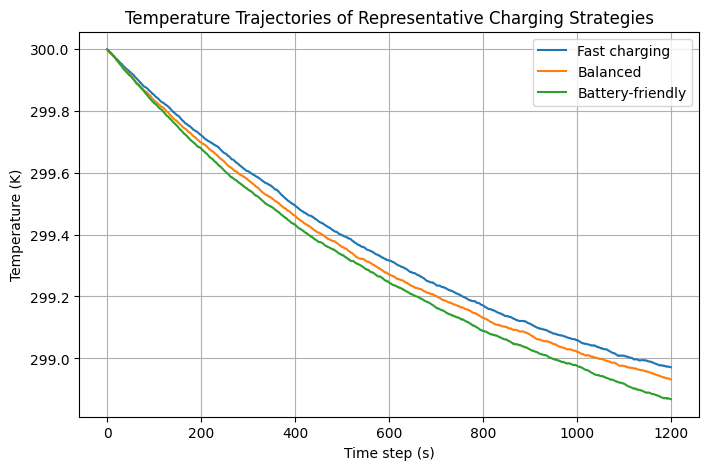

In [62]:
plt.figure(figsize=(8, 5))

for label, profile in profiles.items():
    _, temp_traj = rollout(profile, transformer_state)
    plt.plot(temp_traj, label=label)

plt.xlabel("Time step (s)")
plt.ylabel("Temperature (K)")
plt.title("Temperature Trajectories of Representative Charging Strategies")
plt.legend()
plt.grid(True)
plt.show()

In [63]:
import pandas as pd
import numpy as np

all_rows = []

run_id = 0  # if you only run NSGA-II once

for sol_id, profile in enumerate(pareto_profiles):

    result = simulate_charging(
        profile,
        transformer_state,
        BATTERY_PARAMS,
        log_trajectory=True
    )

    if result is None:
        continue

    _, _, soc_traj, temp_traj, soh_traj = result

    for t in range(len(profile)):
        all_rows.append({
            "run_id": run_id,
            "solution_id": sol_id,
            "time_s": t,
            "current_A": profile[t],
            "SoC": soc_traj[t],
            "temperature_K": temp_traj[t],
            "SoH": soh_traj[t]
        })


In [64]:
df = pd.DataFrame(all_rows)
df.to_csv("nsga2_synthetic_dataset.csv", index=False)

print("Saved synthetic NSGA-II dataset with", len(df), "rows")

Saved synthetic NSGA-II dataset with 72000 rows
